In [1]:
import math
import torch
from torch import nn

#活性化関数Swish

生の入力　×　Sigmoid(x)

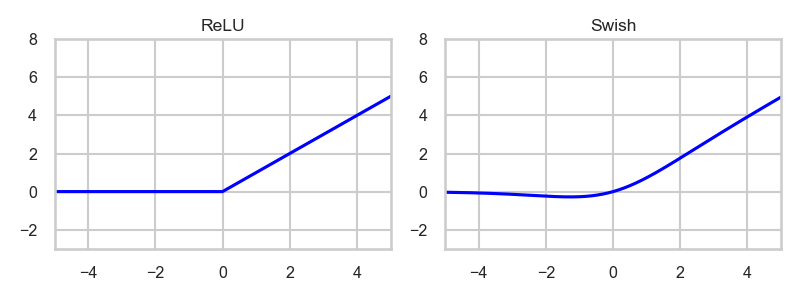

# Model

In [2]:
class Swish(nn.Module):
  def forward(self, x):
    return x * torch.sigmoid(x)

In [3]:
class SEblock(nn.Module):
  def __init__(self, ch_in, ch_sq):
    super().__init__()
    self.se = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(ch_in, ch_sq, 1),
        Swish(),
        nn.Conv2d(ch_sq, ch_in, 1),
    )
    self.se.apply(weight_init)

  def forward(self, x):
    return x * torch.sigmoid(self.se(x))

def weight_init(m):
  if isinstance(m, nn.Conv2d):
    nn.init.kaiming_normal_(m.weight)

  if isinstance(m, nn.Linear):
    nn.init.kaiming_uniform_(m.weight)
    nn.init.zeros_(m.bias)

In [4]:
class ConvBN(nn.Module):
  def __init__(self, ch_in, ch_out, kernel_size, stride=1, padding=0, groups=1):
    super().__init__()
    self.layers=nn.Sequential(
        nn.Conv2d(ch_in, ch_out, kernel_size, stride, padding, groups=groups, bias=False),
        nn.BatchNorm2d(ch_out),
    )
    self.layers.apply(weight_init)

  def forward(self, x):
    return self.layers(x)

In [5]:
class DropConnect(nn.Module):
  def __init__(self, drop_rate):
    super().__init__()
    self.drop_rate=drop_rate

  def forward(self, x):
    if self.training:
      keep_rate=1.0-self.drop_rate
      r = torch.rand([x.size(0),1,1,1], dtype=x.dtype).to(x.device)
      r+=keep_rate
      mask=r.floor()
      return x.div(keep_rate)*mask
    else:
      return x

In [6]:
class BMConvBlock(nn.Module):
  def __init__(self,ch_in,ch_out,expand_ratio,stride,kernel_size,reduction_ratio=4,drop_connect_rate=0.2):
    super().__init__()
    self.use_residual = (ch_in==ch_out) & (stride==1)
    ch_med = int(ch_in*expand_ratio)
    ch_sq  = max(1, ch_in//reduction_ratio)

    if expand_ratio != 1.0:
      layers = [ConvBN(ch_in, ch_med, 1), Swish()]
    else:
      layers = []
    
    layers.extend([ConvBN(ch_med, ch_med, kernel_size, stride=stride, padding=(kernel_size)//2, groups=ch_med),
                  Swish(),
                  SEblock(ch_med, ch_sq),
                  ConvBN(ch_med, ch_out, 1),
                  ])
    
    if self.use_residual:
      self.drop_connect = DropConnect(drop_connect_rate)

    self.layers = nn.Sequential(*layers)

  def forward(self, x):
    if self.use_residual:
      return x + self.drop_connect(self.layers(x))
    else:
      return self.layers(x)

In [7]:
class Flatten(nn.Module):
  def forward(self, x):
    return x.view(x.shape[0], -1)

In [8]:
class EfficientNet(nn.Module):
  def __init__(self,
               width_mult=1.0,
               depth_mult=1.0,
               resolution=False,
               dropout_rate=0.2,
               input_ch=3,
               num_classes=1000):
    super().__init__()

    # expand_ratio, channel, repeats, stride, kernel_size                   
    settings = [
        [1,  16, 1, 1, 3],  # MBConv1_3x3, SE, 112 -> 112                   
        [6,  24, 2, 2, 3],  # MBConv6_3x3, SE, 112 ->  56                   
        [6,  40, 2, 2, 5],  # MBConv6_5x5, SE,  56 ->  28                   
        [6,  80, 3, 2, 3],  # MBConv6_3x3, SE,  28 ->  14                   
        [6, 112, 3, 1, 5],  # MBConv6_5x5, SE,  14 ->  14                   
        [6, 192, 4, 2, 5],  # MBConv6_5x5, SE,  14 ->   7                   
        [6, 320, 1, 1, 3]   # MBConv6_3x3, SE,   7 ->   7]                  
    ]
    ch_out = int(math.ceil(32*width_mult))
    features = [nn.AdaptiveAvgPool2d(resolution)] if resolution else []
    features.extend([ConvBN(input_ch, ch_out, 3, stride=2), Swish()])     # -> [32, 3, 3, 3]

    ch_in = ch_out
    for t, c, n, s, k in settings:
      ch_out = int(math.ceil(c*width_mult))
      repeats = int(math.ceil(n*depth_mult))
      for i in range(repeats):
        stride = s if i==0 else 1
        features.extend([BMConvBlock(ch_in, ch_out, t, stride, k)])
        ch_in = ch_out

    ch_last = int(math.ceil(1280*width_mult))
    features.extend([ConvBN(ch_in, ch_last, 1), Swish()])

    self.features = nn.Sequential(*features)
    self.classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Dropout(dropout_rate),
        nn.Linear(ch_last, num_classes),
    )

  def forward(self, x):
    # print(x.shape)####
    x=self.features(x)
    x=self.classifier(x)
    return x

In [9]:
def _efficientnet(w_mult, d_mult, resolution, drop_rate,
                  input_ch, num_classes=1000):
    model = EfficientNet(w_mult, d_mult,
                         resolution, drop_rate,
                         input_ch, num_classes)
    return model


def efficientnet_b0(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.0, 1.0, 224, 0.2)              
    return _efficientnet(1.0, 1.0, None, 0.2, input_ch, num_classes)

def efficientnet_b1(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.0, 1.1, 240, 0.2)              
    return _efficientnet(1.0, 1.1, None, 0.2, input_ch, num_classes)

def efficientnet_b2(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.1, 1.2, 260, 0.3)              
    return _efficientnet(1.1, 1.2, None, 0.3, input_ch, num_classes)

def efficientnet_b3(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.2, 1.4, 300, 0.3)              
    return _efficientnet(1.2, 1.4, None, 0.3, input_ch, num_classes)

def efficientnet_b4(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.4, 1.8, 380, 0.4)              
    return _efficientnet(1.4, 1.8, None, 0.4, input_ch, num_classes)

def efficientnet_b5(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.6, 2.2, 456, 0.4)              
    return _efficientnet(1.6, 2.2, None, 0.4, input_ch, num_classes)

def efficientnet_b6(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.8, 2.6, 528, 0.5)              
    return _efficientnet(1.8, 2.6, None, 0.5, input_ch, num_classes)

def efficientnet_b7(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (2.0, 3.1, 600, 0.5)              
    return _efficientnet(2.0, 3.1, None, 0.5, input_ch, num_classes)

# Optimizer, Criterion

In [10]:
from torch import optim

model     = efficientnet_b0(num_classes=4).to('cuda')
optimizer = optim.SGD(model.parameters(),lr=0.05)
criterion = nn.CrossEntropyLoss()

# Dataset

In [11]:
import shutil
import os
RESEARCH_WORK_PATH = "/content/drive/MyDrive/Colab Notebooks/BachelorResearch/"


data_dir = "/content/datas/"
if os.path.exists(data_dir):
  shutil.rmtree(data_dir)
for dirs in os.listdir(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/"):
  if "Q" in dirs:
    shutil.copytree(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/" + dirs, data_dir + dirs)

In [12]:
import os
def make_filepath_list(root, train_rate=0.8):
  train_file_list = []
  valid_file_list = []

  for dirs in os.listdir(root):
    if "Q" in dirs:
      file_dir = os.path.join(root, dirs)
      file_list = os.listdir(file_dir)

      num_data = len(file_list)
      num_split = int(num_data * train_rate)

      train_file_list += [os.path.join(root, dirs, file).replace('\\', '/') for file in file_list[:num_split]]
      valid_file_list += [os.path.join(root, dirs, file).replace('\\', '/') for file in file_list[num_split:]]
  
  return train_file_list, valid_file_list


In [13]:
from torch.utils import data
import numpy as np
import librosa
import torch
import cv2

class musicDataset(data.Dataset):

  def __init__(self, file_list, classes, phase='train'):
    self.file_list = file_list
    self.classes = classes
    self.phase = phase

  def __len__(self):
    return len(self.file_list)

  def min_max(self, x): # do min_max normalization ?->https://atmarkit.itmedia.co.jp/ait/articles/2110/07/news027.html
    min = 0
    max = 154.28702 
    # max = 137.74599
    x = np.abs(x)
    result = (x-min)/(max-min)
    return result
    

  def __getitem__(self, index):
    song_path = self.file_list[index]
    wave, sr = librosa.load(song_path)
    
    n_fft = 512
    hop_length = 256
    stft = np.abs(librosa.stft(wave, n_fft=n_fft, hop_length=hop_length))
    stft = self.min_max(stft)
    stft = cv2.cvtColor(stft, cv2.COLOR_GRAY2RGB)
    stft = torch.from_numpy(stft)
    stft = stft.permute(2,1,0)

    label = self.file_list[index].split("/")[-1].split(".")[-3]
    label = self.classes.index(label)

    return stft, label


train_file_list, valid_file_list = make_filepath_list(data_dir)

print('学習データ数 : ', len(train_file_list))
print(train_file_list[0])

print('検証データ数 : ', len(valid_file_list))
print(valid_file_list[0])

q_classes = "Q1 Q2 Q3 Q4".split(" ")

train_dataset = musicDataset(
    file_list=train_file_list, classes=q_classes, phase='train'
)

valid_dataset = musicDataset(
    file_list=valid_file_list, classes=q_classes, phase='valid'
)


index = 0
print("Dataset shape:", train_dataset.__getitem__(index)[0].size())
print("Dataset label:", train_dataset.__getitem__(index)[1])

学習データ数 :  8960
/content/datas/Q2/Q2.MT0004511265_9.wav
検証データ数 :  2240
/content/datas/Q2/Q2.MT0006903607_1.wav
Dataset shape: torch.Size([3, 173, 257])
Dataset label: 1


# DataLoader

In [14]:
# バッチサイズの指定
batch_size = 64

# DataLoaderを作成
train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)

valid_dataloader = data.DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

# pin_mem and num_workers are acceleration technique -> https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587#11-num_workers

# 辞書にまとめる
dataloaders_dict = {
    'train': train_dataloader, 
    'valid': valid_dataloader
}

# 動作確認
# イテレータに変換
batch_iterator = iter(dataloaders_dict['train'])

# 1番目の要素を取り出す
inputs, labels = next(batch_iterator)

print(inputs.size())
print(labels)


torch.Size([64, 3, 173, 257])
tensor([1, 0, 0, 1, 3, 0, 0, 2, 2, 1, 0, 0, 2, 0, 1, 2, 0, 3, 3, 2, 3, 2, 0, 1,
        2, 1, 3, 1, 0, 1, 3, 0, 1, 3, 3, 0, 0, 3, 0, 2, 2, 3, 3, 3, 3, 3, 0, 3,
        2, 2, 1, 2, 0, 0, 0, 3, 3, 1, 2, 0, 1, 0, 3, 2])


# Training

In [ ]:
from tqdm import tqdm
# エポック数
num_epochs = 200

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-------------')
    
    for phase in ['train', 'valid']:
        
        if phase == 'train':
            # モデルを訓練モードに設定
            model.train()
        else:
            # モデルを推論モードに設定
            model.eval()
        
        # 損失和
        epoch_loss = 0.0
        # 正解数
        epoch_corrects = 0
        
        # DataLoaderからデータをバッチごとに取り出す
        with tqdm(dataloaders_dict[phase],unit='batch',colour='green' if phase == 'train' else 'red') as pbar:
          pbar.set_description('['+phase+'] Epoch %d'% (epoch+1))
          for inputs, labels in pbar:
              inputs = inputs.to('cuda')
              labels = labels.to('cuda')
              # optimizerの初期化
              optimizer.zero_grad()
            
              # 学習時のみ勾配を計算させる設定にする
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                
                  # 損失を計算
                  loss = criterion(outputs, labels)
                
                  # ラベルを予測
                  _, preds = torch.max(outputs, 1)
                
                  # 訓練時はバックプロパゲーション
                  if phase == 'train':
                    # 逆伝搬の計算
                    loss.backward()
                    # パラメータの更新
                    optimizer.step()
                
                  # イテレーション結果の計算
                  # lossの合計を更新
                  # PyTorchの仕様上各バッチ内での平均のlossが計算される。
                  # データ数を掛けることで平均から合計に変換をしている。
                  # 損失和は「全データの損失/データ数」で計算されるため、
                  # 平均のままだと損失和を求めることができないため。
                  l = loss.item()
                  epoch_loss += l * inputs.size(0)
                  pbar.set_postfix(dict(loss=l))

                  # 正解数の合計を更新
                  epoch_corrects += torch.sum(preds == labels.data)

        # epochごとのlossと正解率を表示
          epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
          epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch_loss, epoch_acc))

Epoch 1/200
-------------


[train] Epoch 1: 100%|██████████| 140/140 [05:22<00:00,  2.30s/batch, loss=1.17]


train Loss: 1.2573 Acc: 0.3778



[valid] Epoch 1: 100%|██████████| 35/35 [01:16<00:00,  2.18s/batch, loss=1.46]


valid Loss: 1.0918 Acc: 0.4594

Epoch 2/200
-------------


[train] Epoch 2: 100%|██████████| 140/140 [05:13<00:00,  2.24s/batch, loss=1.02]


train Loss: 1.1012 Acc: 0.4632



[valid] Epoch 2: 100%|██████████| 35/35 [01:17<00:00,  2.22s/batch, loss=1.48]


valid Loss: 1.0474 Acc: 0.4991

Epoch 3/200
-------------


[train] Epoch 3: 100%|██████████| 140/140 [05:18<00:00,  2.28s/batch, loss=1.01]


train Loss: 1.0352 Acc: 0.4949



[valid] Epoch 3: 100%|██████████| 35/35 [01:18<00:00,  2.26s/batch, loss=1.24]


valid Loss: 0.9845 Acc: 0.5424

Epoch 4/200
-------------


[train] Epoch 4: 100%|██████████| 140/140 [05:14<00:00,  2.25s/batch, loss=1.09]


train Loss: 0.9899 Acc: 0.5214



[valid] Epoch 4: 100%|██████████| 35/35 [01:16<00:00,  2.19s/batch, loss=1.12]


valid Loss: 0.9680 Acc: 0.5290

Epoch 5/200
-------------


[train] Epoch 5: 100%|██████████| 140/140 [05:15<00:00,  2.26s/batch, loss=0.918]


train Loss: 0.9553 Acc: 0.5383



[valid] Epoch 5: 100%|██████████| 35/35 [01:21<00:00,  2.34s/batch, loss=0.949]


valid Loss: 0.9472 Acc: 0.5661

Epoch 6/200
-------------


[train] Epoch 6: 100%|██████████| 140/140 [05:34<00:00,  2.39s/batch, loss=1.01]


train Loss: 0.9336 Acc: 0.5533



[valid] Epoch 6: 100%|██████████| 35/35 [01:19<00:00,  2.27s/batch, loss=1.05]


valid Loss: 1.0894 Acc: 0.4692

Epoch 7/200
-------------


[train] Epoch 7: 100%|██████████| 140/140 [05:21<00:00,  2.30s/batch, loss=1.06]


train Loss: 0.9042 Acc: 0.5679



[valid] Epoch 7: 100%|██████████| 35/35 [01:18<00:00,  2.23s/batch, loss=0.909]


valid Loss: 0.9135 Acc: 0.5754

Epoch 8/200
-------------


[train] Epoch 8: 100%|██████████| 140/140 [05:17<00:00,  2.27s/batch, loss=0.944]


train Loss: 0.8757 Acc: 0.5828



[valid] Epoch 8: 100%|██████████| 35/35 [01:19<00:00,  2.26s/batch, loss=0.988]


valid Loss: 0.9176 Acc: 0.5826

Epoch 9/200
-------------


[train] Epoch 9: 100%|██████████| 140/140 [05:15<00:00,  2.26s/batch, loss=0.989]


train Loss: 0.8571 Acc: 0.6010



[valid] Epoch 9: 100%|██████████| 35/35 [01:16<00:00,  2.19s/batch, loss=0.762]


valid Loss: 0.9217 Acc: 0.5821

Epoch 10/200
-------------


[train] Epoch 10: 100%|██████████| 140/140 [05:18<00:00,  2.27s/batch, loss=0.824]


train Loss: 0.8406 Acc: 0.6046



[valid] Epoch 10: 100%|██████████| 35/35 [01:18<00:00,  2.25s/batch, loss=0.827]


valid Loss: 0.8724 Acc: 0.6009

Epoch 11/200
-------------


[train] Epoch 11: 100%|██████████| 140/140 [05:16<00:00,  2.26s/batch, loss=0.903]


train Loss: 0.8121 Acc: 0.6209



[valid] Epoch 11: 100%|██████████| 35/35 [01:16<00:00,  2.20s/batch, loss=0.776]


valid Loss: 0.9441 Acc: 0.5902

Epoch 12/200
-------------


[train] Epoch 12: 100%|██████████| 140/140 [05:15<00:00,  2.25s/batch, loss=0.956]


train Loss: 0.7967 Acc: 0.6323



[valid] Epoch 12: 100%|██████████| 35/35 [01:18<00:00,  2.23s/batch, loss=0.773]


valid Loss: 0.8785 Acc: 0.6205

Epoch 13/200
-------------


[train] Epoch 13: 100%|██████████| 140/140 [05:16<00:00,  2.26s/batch, loss=0.755]


train Loss: 0.7746 Acc: 0.6473



[valid] Epoch 13: 100%|██████████| 35/35 [01:16<00:00,  2.18s/batch, loss=0.961]


valid Loss: 0.8817 Acc: 0.5942

Epoch 14/200
-------------


[train] Epoch 14: 100%|██████████| 140/140 [05:13<00:00,  2.24s/batch, loss=0.597]


train Loss: 0.7628 Acc: 0.6493



[valid] Epoch 14: 100%|██████████| 35/35 [01:18<00:00,  2.24s/batch, loss=1.14]


valid Loss: 0.8801 Acc: 0.6223

Epoch 15/200
-------------


[train] Epoch 15: 100%|██████████| 140/140 [05:15<00:00,  2.25s/batch, loss=0.691]


train Loss: 0.7301 Acc: 0.6681



[valid] Epoch 15: 100%|██████████| 35/35 [01:16<00:00,  2.19s/batch, loss=1.32]


valid Loss: 0.9211 Acc: 0.6027

Epoch 16/200
-------------


[train] Epoch 16: 100%|██████████| 140/140 [05:12<00:00,  2.23s/batch, loss=0.745]


train Loss: 0.7073 Acc: 0.6824



[valid] Epoch 16: 100%|██████████| 35/35 [01:19<00:00,  2.29s/batch, loss=0.732]


valid Loss: 0.9100 Acc: 0.6152

Epoch 17/200
-------------


[train] Epoch 17: 100%|██████████| 140/140 [05:18<00:00,  2.27s/batch, loss=0.577]


train Loss: 0.6892 Acc: 0.6962



[valid] Epoch 17: 100%|██████████| 35/35 [01:18<00:00,  2.24s/batch, loss=0.941]


valid Loss: 0.9806 Acc: 0.6062

Epoch 18/200
-------------


[train] Epoch 18: 100%|██████████| 140/140 [05:20<00:00,  2.29s/batch, loss=0.6]


train Loss: 0.6707 Acc: 0.7041



[valid] Epoch 18: 100%|██████████| 35/35 [01:19<00:00,  2.28s/batch, loss=0.944]


valid Loss: 0.8547 Acc: 0.6482

Epoch 19/200
-------------


[train] Epoch 19: 100%|██████████| 140/140 [05:27<00:00,  2.34s/batch, loss=0.509]


train Loss: 0.6440 Acc: 0.7145



[valid] Epoch 19: 100%|██████████| 35/35 [01:17<00:00,  2.22s/batch, loss=1.07]


valid Loss: 0.9416 Acc: 0.5951

Epoch 20/200
-------------


[train] Epoch 20: 100%|██████████| 140/140 [05:20<00:00,  2.29s/batch, loss=0.552]


train Loss: 0.6208 Acc: 0.7281



[valid] Epoch 20: 100%|██████████| 35/35 [01:17<00:00,  2.21s/batch, loss=1.3]


valid Loss: 0.9091 Acc: 0.6415

Epoch 21/200
-------------


[train] Epoch 21: 100%|██████████| 140/140 [05:19<00:00,  2.28s/batch, loss=0.664]


train Loss: 0.6113 Acc: 0.7359



[valid] Epoch 21: 100%|██████████| 35/35 [01:17<00:00,  2.22s/batch, loss=1.29]


valid Loss: 0.9802 Acc: 0.6147

Epoch 22/200
-------------


[train] Epoch 22: 100%|██████████| 140/140 [05:16<00:00,  2.26s/batch, loss=0.488]


train Loss: 0.5756 Acc: 0.7537



[valid] Epoch 22: 100%|██████████| 35/35 [01:17<00:00,  2.22s/batch, loss=0.814]


valid Loss: 0.9490 Acc: 0.6228

Epoch 23/200
-------------


[train] Epoch 23: 100%|██████████| 140/140 [05:23<00:00,  2.31s/batch, loss=0.599]


train Loss: 0.5619 Acc: 0.7600



[valid] Epoch 23: 100%|██████████| 35/35 [01:17<00:00,  2.22s/batch, loss=1.02]


valid Loss: 0.9199 Acc: 0.6397

Epoch 24/200
-------------


[train] Epoch 24: 100%|██████████| 140/140 [05:19<00:00,  2.28s/batch, loss=0.83]


train Loss: 0.5373 Acc: 0.7757



[valid] Epoch 24: 100%|██████████| 35/35 [01:17<00:00,  2.21s/batch, loss=1.01]


valid Loss: 1.0754 Acc: 0.6031

Epoch 25/200
-------------


[train] Epoch 25: 100%|██████████| 140/140 [05:16<00:00,  2.26s/batch, loss=0.513]


train Loss: 0.5260 Acc: 0.7840



[valid] Epoch 25: 100%|██████████| 35/35 [01:17<00:00,  2.21s/batch, loss=1.4]


valid Loss: 0.9635 Acc: 0.6442

Epoch 26/200
-------------


[train] Epoch 26: 100%|██████████| 140/140 [05:19<00:00,  2.28s/batch, loss=0.538]


train Loss: 0.5019 Acc: 0.7883



[valid] Epoch 26: 100%|██████████| 35/35 [01:18<00:00,  2.25s/batch, loss=0.958]


valid Loss: 0.9695 Acc: 0.6402

Epoch 27/200
-------------


[train] Epoch 27: 100%|██████████| 140/140 [05:15<00:00,  2.26s/batch, loss=0.463]


train Loss: 0.4645 Acc: 0.8112



[valid] Epoch 27: 100%|██████████| 35/35 [01:18<00:00,  2.24s/batch, loss=2.6]


valid Loss: 1.2239 Acc: 0.5978

Epoch 28/200
-------------


[train] Epoch 28: 100%|██████████| 140/140 [05:15<00:00,  2.25s/batch, loss=0.416]


train Loss: 0.4545 Acc: 0.8148



[valid] Epoch 28: 100%|██████████| 35/35 [01:16<00:00,  2.19s/batch, loss=0.942]


valid Loss: 1.0437 Acc: 0.6496

Epoch 29/200
-------------


[train] Epoch 29: 100%|██████████| 140/140 [05:18<00:00,  2.27s/batch, loss=0.404]


train Loss: 0.4401 Acc: 0.8201



[valid] Epoch 29: 100%|██████████| 35/35 [01:16<00:00,  2.20s/batch, loss=1.11]


valid Loss: 0.9757 Acc: 0.6625

Epoch 30/200
-------------


[train] Epoch 30: 100%|██████████| 140/140 [05:16<00:00,  2.26s/batch, loss=0.355]


train Loss: 0.4057 Acc: 0.8345



[valid] Epoch 30: 100%|██████████| 35/35 [01:19<00:00,  2.26s/batch, loss=1.34]


valid Loss: 0.9569 Acc: 0.6612

Epoch 31/200
-------------


[train] Epoch 31: 100%|██████████| 140/140 [05:31<00:00,  2.37s/batch, loss=0.474]


train Loss: 0.3892 Acc: 0.8473



[valid] Epoch 31: 100%|██████████| 35/35 [01:15<00:00,  2.17s/batch, loss=1.6]


valid Loss: 1.0255 Acc: 0.6473

Epoch 32/200
-------------


[train] Epoch 32: 100%|██████████| 140/140 [05:17<00:00,  2.27s/batch, loss=0.209]


train Loss: 0.3753 Acc: 0.8501



[valid] Epoch 32: 100%|██████████| 35/35 [01:17<00:00,  2.22s/batch, loss=1.59]


valid Loss: 1.0302 Acc: 0.6687

Epoch 33/200
-------------


[train] Epoch 33: 100%|██████████| 140/140 [05:11<00:00,  2.23s/batch, loss=0.287]


train Loss: 0.3660 Acc: 0.8536



[valid] Epoch 33: 100%|██████████| 35/35 [01:17<00:00,  2.20s/batch, loss=0.676]


valid Loss: 1.1249 Acc: 0.6576

Epoch 34/200
-------------


[train] Epoch 34: 100%|██████████| 140/140 [05:12<00:00,  2.23s/batch, loss=0.551]


train Loss: 0.3524 Acc: 0.8602



[valid] Epoch 34: 100%|██████████| 35/35 [01:16<00:00,  2.18s/batch, loss=1.37]


valid Loss: 1.1345 Acc: 0.6513

Epoch 35/200
-------------


[train] Epoch 35: 100%|██████████| 140/140 [05:12<00:00,  2.23s/batch, loss=0.51]


train Loss: 0.3237 Acc: 0.8758



[valid] Epoch 35: 100%|██████████| 35/35 [01:16<00:00,  2.18s/batch, loss=1.36]


valid Loss: 1.1746 Acc: 0.6562

Epoch 36/200
-------------


[train] Epoch 36: 100%|██████████| 140/140 [05:18<00:00,  2.28s/batch, loss=0.326]


train Loss: 0.3162 Acc: 0.8767



[valid] Epoch 36: 100%|██████████| 35/35 [01:18<00:00,  2.24s/batch, loss=1.44]


valid Loss: 1.2240 Acc: 0.6656

Epoch 37/200
-------------


[train] Epoch 37: 100%|██████████| 140/140 [05:10<00:00,  2.22s/batch, loss=0.232]


train Loss: 0.3025 Acc: 0.8845



[valid] Epoch 37: 100%|██████████| 35/35 [01:16<00:00,  2.19s/batch, loss=1.33]


valid Loss: 1.1044 Acc: 0.6540

Epoch 38/200
-------------


[train] Epoch 38: 100%|██████████| 140/140 [05:10<00:00,  2.22s/batch, loss=0.437]


train Loss: 0.2835 Acc: 0.8844



[valid] Epoch 38: 100%|██████████| 35/35 [01:16<00:00,  2.18s/batch, loss=1.22]


valid Loss: 1.0851 Acc: 0.6576

Epoch 39/200
-------------


[train] Epoch 39: 100%|██████████| 140/140 [05:11<00:00,  2.23s/batch, loss=0.491]


train Loss: 0.2792 Acc: 0.8935



[valid] Epoch 39: 100%|██████████| 35/35 [01:18<00:00,  2.23s/batch, loss=1.09]


valid Loss: 1.1198 Acc: 0.6621

Epoch 40/200
-------------


[train] Epoch 40: 100%|██████████| 140/140 [05:13<00:00,  2.24s/batch, loss=0.352]


train Loss: 0.2811 Acc: 0.8933



[valid] Epoch 40: 100%|██████████| 35/35 [01:15<00:00,  2.17s/batch, loss=1.83]


valid Loss: 1.3943 Acc: 0.6446

Epoch 41/200
-------------


[train] Epoch 41: 100%|██████████| 140/140 [05:11<00:00,  2.23s/batch, loss=0.256]


train Loss: 0.2489 Acc: 0.9056



[valid] Epoch 41: 100%|██████████| 35/35 [01:16<00:00,  2.18s/batch, loss=1.47]


valid Loss: 1.2326 Acc: 0.6643

Epoch 42/200
-------------


[train] Epoch 42: 100%|██████████| 140/140 [05:12<00:00,  2.23s/batch, loss=0.157]


train Loss: 0.2351 Acc: 0.9094



[valid] Epoch 42: 100%|██████████| 35/35 [01:16<00:00,  2.17s/batch, loss=2.23]


valid Loss: 1.4524 Acc: 0.6366

Epoch 43/200
-------------


[train] Epoch 43: 100%|██████████| 140/140 [05:13<00:00,  2.24s/batch, loss=0.248]


train Loss: 0.2275 Acc: 0.9131



[valid] Epoch 43: 100%|██████████| 35/35 [01:17<00:00,  2.22s/batch, loss=0.736]


valid Loss: 1.3527 Acc: 0.6665

Epoch 44/200
-------------


[train] Epoch 44: 100%|██████████| 140/140 [05:12<00:00,  2.23s/batch, loss=0.258]


train Loss: 0.2194 Acc: 0.9180



[valid] Epoch 44: 100%|██████████| 35/35 [01:16<00:00,  2.18s/batch, loss=1.89]


valid Loss: 1.3852 Acc: 0.6701

Epoch 45/200
-------------


[train] Epoch 45: 100%|██████████| 140/140 [05:13<00:00,  2.24s/batch, loss=0.28]


train Loss: 0.1980 Acc: 0.9263



[valid] Epoch 45: 100%|██████████| 35/35 [01:15<00:00,  2.17s/batch, loss=1.97]


valid Loss: 1.6067 Acc: 0.6473

Epoch 46/200
-------------


[train] Epoch 46: 100%|██████████| 140/140 [05:13<00:00,  2.24s/batch, loss=0.149]


train Loss: 0.1922 Acc: 0.9282



[valid] Epoch 46: 100%|██████████| 35/35 [01:16<00:00,  2.18s/batch, loss=1.33]


valid Loss: 1.3582 Acc: 0.6719

Epoch 47/200
-------------


[train] Epoch 47: 100%|██████████| 140/140 [05:12<00:00,  2.23s/batch, loss=0.0976]


train Loss: 0.1896 Acc: 0.9283



[valid] Epoch 47: 100%|██████████| 35/35 [01:19<00:00,  2.26s/batch, loss=2.2]


valid Loss: 1.4245 Acc: 0.6589

Epoch 48/200
-------------


[train] Epoch 48: 100%|██████████| 140/140 [05:18<00:00,  2.27s/batch, loss=0.0904]


train Loss: 0.1935 Acc: 0.9304



[valid] Epoch 48: 100%|██████████| 35/35 [01:17<00:00,  2.21s/batch, loss=2.07]


valid Loss: 1.3802 Acc: 0.6643

Epoch 49/200
-------------


[train] Epoch 49: 100%|██████████| 140/140 [05:16<00:00,  2.26s/batch, loss=0.158]


train Loss: 0.1930 Acc: 0.9259



[valid] Epoch 49: 100%|██████████| 35/35 [01:16<00:00,  2.19s/batch, loss=1.99]


valid Loss: 1.2793 Acc: 0.6902

Epoch 50/200
-------------


[train] Epoch 50: 100%|██████████| 140/140 [05:16<00:00,  2.26s/batch, loss=0.191]


train Loss: 0.1867 Acc: 0.9280



[valid] Epoch 50: 100%|██████████| 35/35 [01:18<00:00,  2.23s/batch, loss=1.11]


valid Loss: 1.3084 Acc: 0.6638

Epoch 51/200
-------------


[train] Epoch 51: 100%|██████████| 140/140 [05:18<00:00,  2.27s/batch, loss=0.126]


train Loss: 0.1629 Acc: 0.9366



[valid] Epoch 51: 100%|██████████| 35/35 [01:16<00:00,  2.20s/batch, loss=1.69]


valid Loss: 1.3306 Acc: 0.6839

Epoch 52/200
-------------


[train] Epoch 52: 100%|██████████| 140/140 [05:16<00:00,  2.26s/batch, loss=0.239]


train Loss: 0.1638 Acc: 0.9386



[valid] Epoch 52: 100%|██████████| 35/35 [01:16<00:00,  2.20s/batch, loss=1.22]


valid Loss: 1.4173 Acc: 0.6643

Epoch 53/200
-------------


[train] Epoch 53: 100%|██████████| 140/140 [05:22<00:00,  2.30s/batch, loss=0.0981]


train Loss: 0.1574 Acc: 0.9404



[valid] Epoch 53: 100%|██████████| 35/35 [01:20<00:00,  2.30s/batch, loss=1.2]


valid Loss: 1.5167 Acc: 0.6821

Epoch 54/200
-------------


[train] Epoch 54: 100%|██████████| 140/140 [05:19<00:00,  2.28s/batch, loss=0.371]


train Loss: 0.1540 Acc: 0.9425



[valid] Epoch 54: 100%|██████████| 35/35 [01:17<00:00,  2.22s/batch, loss=1.08]


valid Loss: 1.7098 Acc: 0.6205

Epoch 55/200
-------------


[train] Epoch 55: 100%|██████████| 140/140 [05:21<00:00,  2.29s/batch, loss=0.172]


train Loss: 0.1442 Acc: 0.9470



[valid] Epoch 55: 100%|██████████| 35/35 [01:17<00:00,  2.22s/batch, loss=2.07]


valid Loss: 1.4834 Acc: 0.6710

Epoch 56/200
-------------


[train] Epoch 56: 100%|██████████| 140/140 [05:19<00:00,  2.28s/batch, loss=0.247]


train Loss: 0.1442 Acc: 0.9442



[valid] Epoch 56: 100%|██████████| 35/35 [01:19<00:00,  2.26s/batch, loss=1.97]


valid Loss: 1.4073 Acc: 0.6920

Epoch 57/200
-------------


[train] Epoch 57: 100%|██████████| 140/140 [05:19<00:00,  2.28s/batch, loss=0.128]


train Loss: 0.1265 Acc: 0.9518



[valid] Epoch 57: 100%|██████████| 35/35 [01:17<00:00,  2.22s/batch, loss=1.66]


valid Loss: 1.5063 Acc: 0.6759

Epoch 58/200
-------------


[train] Epoch 58: 100%|██████████| 140/140 [05:20<00:00,  2.29s/batch, loss=0.132]


train Loss: 0.1259 Acc: 0.9539



[valid] Epoch 58: 100%|██████████| 35/35 [01:19<00:00,  2.28s/batch, loss=1.4]


valid Loss: 1.4450 Acc: 0.6835

Epoch 59/200
-------------


[train] Epoch 59: 100%|██████████| 140/140 [05:24<00:00,  2.31s/batch, loss=0.092]


train Loss: 0.1201 Acc: 0.9566



[valid] Epoch 59: 100%|██████████| 35/35 [01:18<00:00,  2.24s/batch, loss=2]


valid Loss: 1.4996 Acc: 0.6875

Epoch 60/200
-------------


[train] Epoch 60: 100%|██████████| 140/140 [05:20<00:00,  2.29s/batch, loss=0.197]


train Loss: 0.1246 Acc: 0.9551



[valid] Epoch 60: 100%|██████████| 35/35 [01:16<00:00,  2.19s/batch, loss=1.18]


valid Loss: 1.3880 Acc: 0.6929

Epoch 61/200
-------------


[train] Epoch 61: 100%|██████████| 140/140 [05:15<00:00,  2.25s/batch, loss=0.0782]


train Loss: 0.1153 Acc: 0.9562



[valid] Epoch 61: 100%|██████████| 35/35 [01:16<00:00,  2.19s/batch, loss=1.76]


valid Loss: 1.4017 Acc: 0.6973

Epoch 62/200
-------------


[train] Epoch 62: 100%|██████████| 140/140 [05:16<00:00,  2.26s/batch, loss=0.144]


train Loss: 0.1092 Acc: 0.9590



[valid] Epoch 62: 100%|██████████| 35/35 [01:17<00:00,  2.22s/batch, loss=1.6]


valid Loss: 1.4839 Acc: 0.6723

Epoch 63/200
-------------


[train] Epoch 63: 100%|██████████| 140/140 [05:20<00:00,  2.29s/batch, loss=0.0253]


train Loss: 0.0979 Acc: 0.9628



[valid] Epoch 63: 100%|██████████| 35/35 [01:17<00:00,  2.20s/batch, loss=1.8]


valid Loss: 1.5033 Acc: 0.6893

Epoch 64/200
-------------


[train] Epoch 64: 100%|██████████| 140/140 [05:20<00:00,  2.29s/batch, loss=0.0895]


train Loss: 0.1034 Acc: 0.9628



[valid] Epoch 64: 100%|██████████| 35/35 [01:18<00:00,  2.24s/batch, loss=1.52]


valid Loss: 1.4648 Acc: 0.6906

Epoch 65/200
-------------


[train] Epoch 65: 100%|██████████| 140/140 [05:19<00:00,  2.28s/batch, loss=0.106]


train Loss: 0.1046 Acc: 0.9606



[valid] Epoch 65: 100%|██████████| 35/35 [01:20<00:00,  2.31s/batch, loss=1.05]


valid Loss: 1.5864 Acc: 0.6732

Epoch 66/200
-------------


[train] Epoch 66: 100%|██████████| 140/140 [05:19<00:00,  2.28s/batch, loss=0.0427]


train Loss: 0.0925 Acc: 0.9648



[valid] Epoch 66: 100%|██████████| 35/35 [01:17<00:00,  2.21s/batch, loss=2.32]


valid Loss: 1.6129 Acc: 0.6656

Epoch 67/200
-------------


[train] Epoch 67: 100%|██████████| 140/140 [05:17<00:00,  2.27s/batch, loss=0.0968]


train Loss: 0.0920 Acc: 0.9670



[valid] Epoch 67: 100%|██████████| 35/35 [01:17<00:00,  2.21s/batch, loss=1.01]


valid Loss: 1.5111 Acc: 0.6759

Epoch 68/200
-------------


[train] Epoch 68: 100%|██████████| 140/140 [05:17<00:00,  2.27s/batch, loss=0.0812]


train Loss: 0.0860 Acc: 0.9675



[valid] Epoch 68: 100%|██████████| 35/35 [01:20<00:00,  2.29s/batch, loss=1.93]


valid Loss: 1.5784 Acc: 0.6795

Epoch 69/200
-------------


[train] Epoch 69: 100%|██████████| 140/140 [05:22<00:00,  2.31s/batch, loss=0.0557]


train Loss: 0.0870 Acc: 0.9684



[valid] Epoch 69: 100%|██████████| 35/35 [01:17<00:00,  2.22s/batch, loss=1.87]


valid Loss: 1.5952 Acc: 0.6808

Epoch 70/200
-------------


[train] Epoch 70: 100%|██████████| 140/140 [05:20<00:00,  2.29s/batch, loss=0.0306]


train Loss: 0.0930 Acc: 0.9677



[valid] Epoch 70: 100%|██████████| 35/35 [01:19<00:00,  2.26s/batch, loss=2.09]


valid Loss: 1.5174 Acc: 0.6866

Epoch 71/200
-------------


[train] Epoch 71: 100%|██████████| 140/140 [05:21<00:00,  2.29s/batch, loss=0.0866]


train Loss: 0.0870 Acc: 0.9682



[valid] Epoch 71: 100%|██████████| 35/35 [01:18<00:00,  2.25s/batch, loss=2.52]


valid Loss: 1.6014 Acc: 0.6866

Epoch 72/200
-------------


[train] Epoch 72: 100%|██████████| 140/140 [05:22<00:00,  2.30s/batch, loss=0.0808]


train Loss: 0.0834 Acc: 0.9688



[valid] Epoch 72: 100%|██████████| 35/35 [01:20<00:00,  2.29s/batch, loss=1.5]


valid Loss: 1.6291 Acc: 0.6821

Epoch 73/200
-------------


[train] Epoch 73: 100%|██████████| 140/140 [05:21<00:00,  2.29s/batch, loss=0.0425]


train Loss: 0.0821 Acc: 0.9708



[valid] Epoch 73: 100%|██████████| 35/35 [01:17<00:00,  2.23s/batch, loss=2.33]


valid Loss: 1.6106 Acc: 0.6808

Epoch 74/200
-------------


[train] Epoch 74: 100%|██████████| 140/140 [05:24<00:00,  2.32s/batch, loss=0.192]


train Loss: 0.0749 Acc: 0.9740



[valid] Epoch 74: 100%|██████████| 35/35 [01:18<00:00,  2.25s/batch, loss=2.75]


valid Loss: 1.6399 Acc: 0.6884

Epoch 75/200
-------------


[train] Epoch 75: 100%|██████████| 140/140 [05:25<00:00,  2.32s/batch, loss=0.0186]


train Loss: 0.0772 Acc: 0.9728



[valid] Epoch 75: 100%|██████████| 35/35 [01:18<00:00,  2.23s/batch, loss=1.69]


valid Loss: 1.7389 Acc: 0.6732

Epoch 76/200
-------------


[train] Epoch 76: 100%|██████████| 140/140 [05:24<00:00,  2.32s/batch, loss=0.152]


train Loss: 0.0768 Acc: 0.9746



[valid] Epoch 76: 100%|██████████| 35/35 [01:18<00:00,  2.24s/batch, loss=1.13]


valid Loss: 1.9070 Acc: 0.6656

Epoch 77/200
-------------


[train] Epoch 77: 100%|██████████| 140/140 [05:24<00:00,  2.31s/batch, loss=0.17]


train Loss: 0.0640 Acc: 0.9777



[valid] Epoch 77: 100%|██████████| 35/35 [01:20<00:00,  2.30s/batch, loss=1.85]


valid Loss: 1.6677 Acc: 0.6808

Epoch 78/200
-------------


[train] Epoch 78: 100%|██████████| 140/140 [05:22<00:00,  2.31s/batch, loss=0.0798]


train Loss: 0.0705 Acc: 0.9743



[valid] Epoch 78: 100%|██████████| 35/35 [01:18<00:00,  2.23s/batch, loss=1.73]


valid Loss: 1.7137 Acc: 0.6768

Epoch 79/200
-------------


[train] Epoch 79: 100%|██████████| 140/140 [05:23<00:00,  2.31s/batch, loss=0.32]


train Loss: 0.0698 Acc: 0.9756



[valid] Epoch 79: 100%|██████████| 35/35 [01:18<00:00,  2.23s/batch, loss=2.01]


valid Loss: 1.7043 Acc: 0.6763

Epoch 80/200
-------------


[train] Epoch 80: 100%|██████████| 140/140 [05:18<00:00,  2.27s/batch, loss=0.0172]


train Loss: 0.0705 Acc: 0.9740



[valid] Epoch 80: 100%|██████████| 35/35 [01:19<00:00,  2.27s/batch, loss=1.13]


valid Loss: 1.7030 Acc: 0.6813

Epoch 81/200
-------------


[train] Epoch 81: 100%|██████████| 140/140 [05:13<00:00,  2.24s/batch, loss=0.11]


train Loss: 0.0707 Acc: 0.9746



[valid] Epoch 81: 100%|██████████| 35/35 [01:16<00:00,  2.20s/batch, loss=2.51]


valid Loss: 1.6733 Acc: 0.6902

Epoch 82/200
-------------


[train] Epoch 82: 100%|██████████| 140/140 [05:19<00:00,  2.28s/batch, loss=0.0618]


train Loss: 0.0548 Acc: 0.9794



[valid] Epoch 82: 100%|██████████| 35/35 [01:17<00:00,  2.21s/batch, loss=2.67]


valid Loss: 1.6565 Acc: 0.6951

Epoch 83/200
-------------


[train] Epoch 83: 100%|██████████| 140/140 [05:22<00:00,  2.30s/batch, loss=0.0241]


train Loss: 0.0602 Acc: 0.9776



[valid] Epoch 83: 100%|██████████| 35/35 [01:19<00:00,  2.26s/batch, loss=2.06]


valid Loss: 1.8434 Acc: 0.6750

Epoch 84/200
-------------


[train] Epoch 84: 100%|██████████| 140/140 [05:20<00:00,  2.29s/batch, loss=0.0166]


train Loss: 0.0586 Acc: 0.9796



[valid] Epoch 84: 100%|██████████| 35/35 [01:19<00:00,  2.27s/batch, loss=2.13]


valid Loss: 1.6716 Acc: 0.6929

Epoch 85/200
-------------


[train] Epoch 85: 100%|██████████| 140/140 [05:20<00:00,  2.29s/batch, loss=0.031]


train Loss: 0.0609 Acc: 0.9770



[valid] Epoch 85: 100%|██████████| 35/35 [01:17<00:00,  2.22s/batch, loss=1.88]


valid Loss: 1.7164 Acc: 0.6875

Epoch 86/200
-------------


[train] Epoch 86: 100%|██████████| 140/140 [05:23<00:00,  2.31s/batch, loss=0.0798]


train Loss: 0.0633 Acc: 0.9781



[valid] Epoch 86: 100%|██████████| 35/35 [01:17<00:00,  2.22s/batch, loss=2.6]


valid Loss: 1.6673 Acc: 0.6862

Epoch 87/200
-------------


[train] Epoch 87: 100%|██████████| 140/140 [05:21<00:00,  2.30s/batch, loss=0.0642]


train Loss: 0.0576 Acc: 0.9794



[valid] Epoch 87: 100%|██████████| 35/35 [01:19<00:00,  2.27s/batch, loss=2.42]


valid Loss: 1.6600 Acc: 0.6991

Epoch 88/200
-------------


[train] Epoch 88: 100%|██████████| 140/140 [05:20<00:00,  2.29s/batch, loss=0.0213]


train Loss: 0.0511 Acc: 0.9820



[valid] Epoch 88: 100%|██████████| 35/35 [01:18<00:00,  2.26s/batch, loss=2.09]


valid Loss: 1.6861 Acc: 0.6996

Epoch 89/200
-------------


[train] Epoch 89: 100%|██████████| 140/140 [05:25<00:00,  2.32s/batch, loss=0.0905]


train Loss: 0.0577 Acc: 0.9821



[valid] Epoch 89: 100%|██████████| 35/35 [01:17<00:00,  2.22s/batch, loss=2.55]


valid Loss: 1.7221 Acc: 0.6884

Epoch 90/200
-------------


[train] Epoch 90: 100%|██████████| 140/140 [05:22<00:00,  2.30s/batch, loss=0.0112]


train Loss: 0.0511 Acc: 0.9830



[valid] Epoch 90: 100%|██████████| 35/35 [01:17<00:00,  2.22s/batch, loss=2.15]


valid Loss: 1.7778 Acc: 0.6737

Epoch 91/200
-------------


[train] Epoch 91: 100%|██████████| 140/140 [05:19<00:00,  2.29s/batch, loss=0.0418]


train Loss: 0.0458 Acc: 0.9844



[valid] Epoch 91: 100%|██████████| 35/35 [01:19<00:00,  2.27s/batch, loss=2.82]


valid Loss: 1.8138 Acc: 0.6799

Epoch 92/200
-------------


[train] Epoch 92: 100%|██████████| 140/140 [05:18<00:00,  2.28s/batch, loss=0.00289]


train Loss: 0.0446 Acc: 0.9840



[valid] Epoch 92: 100%|██████████| 35/35 [01:19<00:00,  2.27s/batch, loss=2.02]


valid Loss: 1.8151 Acc: 0.6808

Epoch 93/200
-------------


[train] Epoch 93: 100%|██████████| 140/140 [05:24<00:00,  2.31s/batch, loss=0.0533]


train Loss: 0.0597 Acc: 0.9792



[valid] Epoch 93: 100%|██████████| 35/35 [01:19<00:00,  2.27s/batch, loss=1.97]


valid Loss: 1.7441 Acc: 0.6839

Epoch 94/200
-------------


[train] Epoch 94: 100%|██████████| 140/140 [05:21<00:00,  2.30s/batch, loss=0.035]


train Loss: 0.0593 Acc: 0.9771



[valid] Epoch 94: 100%|██████████| 35/35 [01:17<00:00,  2.23s/batch, loss=2.73]


valid Loss: 1.8804 Acc: 0.6835

Epoch 95/200
-------------


[train] Epoch 95: 100%|██████████| 140/140 [05:24<00:00,  2.32s/batch, loss=0.0506]


train Loss: 0.0409 Acc: 0.9859



[valid] Epoch 95: 100%|██████████| 35/35 [01:18<00:00,  2.26s/batch, loss=1.61]


valid Loss: 1.8058 Acc: 0.6942

Epoch 96/200
-------------


[train] Epoch 96: 100%|██████████| 140/140 [05:23<00:00,  2.31s/batch, loss=0.00937]


train Loss: 0.0456 Acc: 0.9836



[valid] Epoch 96: 100%|██████████| 35/35 [01:18<00:00,  2.24s/batch, loss=2.02]


valid Loss: 1.7465 Acc: 0.6915

Epoch 97/200
-------------


[train] Epoch 97: 100%|██████████| 140/140 [05:23<00:00,  2.31s/batch, loss=0.0142]


train Loss: 0.0483 Acc: 0.9812



[valid] Epoch 97: 100%|██████████| 35/35 [01:17<00:00,  2.22s/batch, loss=1.21]


valid Loss: 1.7967 Acc: 0.6982

Epoch 98/200
-------------


[train] Epoch 98: 100%|██████████| 140/140 [05:23<00:00,  2.31s/batch, loss=0.0458]


train Loss: 0.0485 Acc: 0.9821



[valid] Epoch 98: 100%|██████████| 35/35 [01:18<00:00,  2.23s/batch, loss=2.23]


valid Loss: 1.8161 Acc: 0.6888

Epoch 99/200
-------------


[train] Epoch 99: 100%|██████████| 140/140 [05:24<00:00,  2.32s/batch, loss=0.0113]


train Loss: 0.0434 Acc: 0.9839



[valid] Epoch 99: 100%|██████████| 35/35 [01:18<00:00,  2.24s/batch, loss=2.68]


valid Loss: 1.7476 Acc: 0.6902

Epoch 100/200
-------------


[train] Epoch 100: 100%|██████████| 140/140 [05:25<00:00,  2.33s/batch, loss=0.0604]


train Loss: 0.0463 Acc: 0.9827



[valid] Epoch 100: 100%|██████████| 35/35 [01:19<00:00,  2.26s/batch, loss=2.22]


valid Loss: 1.6597 Acc: 0.7027

Epoch 101/200
-------------


[train] Epoch 101: 100%|██████████| 140/140 [05:24<00:00,  2.32s/batch, loss=0.00536]


train Loss: 0.0394 Acc: 0.9864



[valid] Epoch 101: 100%|██████████| 35/35 [01:20<00:00,  2.30s/batch, loss=2.28]


valid Loss: 1.7445 Acc: 0.7062

Epoch 102/200
-------------


[train] Epoch 102: 100%|██████████| 140/140 [05:26<00:00,  2.33s/batch, loss=0.0271]


train Loss: 0.0391 Acc: 0.9867



[valid] Epoch 102: 100%|██████████| 35/35 [01:19<00:00,  2.26s/batch, loss=2.31]


valid Loss: 1.8598 Acc: 0.6906

Epoch 103/200
-------------


[train] Epoch 103: 100%|██████████| 140/140 [05:27<00:00,  2.34s/batch, loss=0.0299]


train Loss: 0.0345 Acc: 0.9875



[valid] Epoch 103: 100%|██████████| 35/35 [01:19<00:00,  2.28s/batch, loss=2.19]


valid Loss: 1.9177 Acc: 0.6746

Epoch 104/200
-------------


[train] Epoch 104: 100%|██████████| 140/140 [05:26<00:00,  2.33s/batch, loss=0.024]


train Loss: 0.0362 Acc: 0.9885



[valid] Epoch 104: 100%|██████████| 35/35 [01:19<00:00,  2.28s/batch, loss=2.42]


valid Loss: 1.8972 Acc: 0.6902

Epoch 105/200
-------------


[train] Epoch 105: 100%|██████████| 140/140 [05:26<00:00,  2.33s/batch, loss=0.0124]


train Loss: 0.0351 Acc: 0.9888



[valid] Epoch 105: 100%|██████████| 35/35 [01:20<00:00,  2.29s/batch, loss=2.04]


valid Loss: 1.7887 Acc: 0.6996

Epoch 106/200
-------------


[train] Epoch 106: 100%|██████████| 140/140 [05:23<00:00,  2.31s/batch, loss=0.00281]


train Loss: 0.0322 Acc: 0.9885



[valid] Epoch 106: 100%|██████████| 35/35 [01:21<00:00,  2.32s/batch, loss=2.02]


valid Loss: 1.9118 Acc: 0.6906

Epoch 107/200
-------------


[train] Epoch 107: 100%|██████████| 140/140 [05:28<00:00,  2.35s/batch, loss=0.0208]


train Loss: 0.0309 Acc: 0.9890



[valid] Epoch 107: 100%|██████████| 35/35 [01:21<00:00,  2.32s/batch, loss=2.04]


valid Loss: 1.9199 Acc: 0.6750

Epoch 108/200
-------------


[train] Epoch 108: 100%|██████████| 140/140 [05:28<00:00,  2.35s/batch, loss=0.0627]


train Loss: 0.0360 Acc: 0.9879



[valid] Epoch 108: 100%|██████████| 35/35 [01:19<00:00,  2.26s/batch, loss=2.02]


valid Loss: 1.9583 Acc: 0.6929

Epoch 109/200
-------------


[train] Epoch 109: 100%|██████████| 140/140 [05:28<00:00,  2.34s/batch, loss=0.0105]


train Loss: 0.0376 Acc: 0.9874



[valid] Epoch 109: 100%|██████████| 35/35 [01:20<00:00,  2.30s/batch, loss=1.87]


valid Loss: 1.9005 Acc: 0.6929

Epoch 110/200
-------------


[train] Epoch 110: 100%|██████████| 140/140 [05:28<00:00,  2.35s/batch, loss=0.0438]


train Loss: 0.0324 Acc: 0.9886



[valid] Epoch 110: 100%|██████████| 35/35 [01:18<00:00,  2.25s/batch, loss=1.94]


valid Loss: 1.8209 Acc: 0.6955

Epoch 111/200
-------------


[train] Epoch 111: 100%|██████████| 140/140 [05:23<00:00,  2.31s/batch, loss=0.0132]


train Loss: 0.0272 Acc: 0.9911



[valid] Epoch 111: 100%|██████████| 35/35 [01:20<00:00,  2.29s/batch, loss=2.03]


valid Loss: 1.9508 Acc: 0.6929

Epoch 112/200
-------------


[train] Epoch 112: 100%|██████████| 140/140 [05:23<00:00,  2.31s/batch, loss=0.012]


train Loss: 0.0313 Acc: 0.9890



[valid] Epoch 112: 100%|██████████| 35/35 [01:20<00:00,  2.30s/batch, loss=1.48]


valid Loss: 1.8981 Acc: 0.6942

Epoch 113/200
-------------


[train] Epoch 113: 100%|██████████| 140/140 [05:23<00:00,  2.31s/batch, loss=0.21]


train Loss: 0.0325 Acc: 0.9891



[valid] Epoch 113: 100%|██████████| 35/35 [01:18<00:00,  2.25s/batch, loss=1.42]


valid Loss: 2.0416 Acc: 0.6826

Epoch 114/200
-------------


[train] Epoch 114: 100%|██████████| 140/140 [05:22<00:00,  2.30s/batch, loss=0.000736]


train Loss: 0.0368 Acc: 0.9888



[valid] Epoch 114: 100%|██████████| 35/35 [01:20<00:00,  2.29s/batch, loss=2.23]


valid Loss: 1.8617 Acc: 0.6906

Epoch 115/200
-------------


[train] Epoch 115: 100%|██████████| 140/140 [05:23<00:00,  2.31s/batch, loss=0.0179]


train Loss: 0.0327 Acc: 0.9888



[valid] Epoch 115: 100%|██████████| 35/35 [01:20<00:00,  2.30s/batch, loss=2.46]


valid Loss: 1.9091 Acc: 0.6937

Epoch 116/200
-------------


[train] Epoch 116: 100%|██████████| 140/140 [05:25<00:00,  2.32s/batch, loss=0.00341]


train Loss: 0.0319 Acc: 0.9887



[valid] Epoch 116: 100%|██████████| 35/35 [01:18<00:00,  2.24s/batch, loss=2.23]


valid Loss: 1.8612 Acc: 0.6937

Epoch 117/200
-------------


[train] Epoch 117: 100%|██████████| 140/140 [05:24<00:00,  2.32s/batch, loss=0.00716]


train Loss: 0.0327 Acc: 0.9890



[valid] Epoch 117: 100%|██████████| 35/35 [01:19<00:00,  2.28s/batch, loss=2.75]


valid Loss: 1.8775 Acc: 0.6951

Epoch 118/200
-------------


[train] Epoch 118: 100%|██████████| 140/140 [05:22<00:00,  2.31s/batch, loss=0.00681]


train Loss: 0.0242 Acc: 0.9916



[valid] Epoch 118: 100%|██████████| 35/35 [01:17<00:00,  2.22s/batch, loss=2.07]


valid Loss: 1.8784 Acc: 0.6973

Epoch 119/200
-------------


[train] Epoch 119: 100%|██████████| 140/140 [05:20<00:00,  2.29s/batch, loss=0.0205]


train Loss: 0.0237 Acc: 0.9914



[valid] Epoch 119: 100%|██████████| 35/35 [01:16<00:00,  2.20s/batch, loss=2.88]


valid Loss: 1.9202 Acc: 0.6920

Epoch 120/200
-------------


[train] Epoch 120: 100%|██████████| 140/140 [05:19<00:00,  2.28s/batch, loss=0.0451]


train Loss: 0.0330 Acc: 0.9884



[valid] Epoch 120: 100%|██████████| 35/35 [01:18<00:00,  2.25s/batch, loss=2.45]


valid Loss: 1.9778 Acc: 0.6897

Epoch 121/200
-------------


[train] Epoch 121: 100%|██████████| 140/140 [05:16<00:00,  2.26s/batch, loss=0.0353]


train Loss: 0.0297 Acc: 0.9905



[valid] Epoch 121: 100%|██████████| 35/35 [01:18<00:00,  2.25s/batch, loss=1.69]


valid Loss: 2.0540 Acc: 0.6786

Epoch 122/200
-------------


[train] Epoch 122: 100%|██████████| 140/140 [05:16<00:00,  2.26s/batch, loss=0.00777]


train Loss: 0.0280 Acc: 0.9901



[valid] Epoch 122: 100%|██████████| 35/35 [01:19<00:00,  2.26s/batch, loss=2]


valid Loss: 1.9323 Acc: 0.6902

Epoch 123/200
-------------


[train] Epoch 123: 100%|██████████| 140/140 [05:18<00:00,  2.27s/batch, loss=0.031]


train Loss: 0.0263 Acc: 0.9907



[valid] Epoch 123: 100%|██████████| 35/35 [01:16<00:00,  2.19s/batch, loss=3.03]


valid Loss: 1.9167 Acc: 0.7036

Epoch 124/200
-------------


[train] Epoch 124:  64%|██████▍   | 90/140 [03:28<01:38,  1.98s/batch, loss=0.00326] 

# 疑問点
入力画素数はどこでわかる？

特徴抽出層featuresを2つ用意して、画像と配列それぞれに対して学習すればいいということ？

画像層のグレースケール化は可能？

